<a href="https://colab.research.google.com/github/cfong32/key-sentence-extraction/blob/main/exp5_tfidf_cossim_rouge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets rouge_score

In [17]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score.rouge_scorer import RougeScorer
from itertools import cycle
pd.set_option('display.min_rows', 4)
tqdm.pandas()

# Calculate TF-IDF Cosine-similarity (to the article) and ROUGE (to the highlights) on the CNN/DM Dataset

In [39]:
# load dataset into a dataframe

DATASET = 'cnn_dailymail'
CONFIG  = '3.0.0'
SUBSET  = 'test'

dataset = load_dataset(DATASET, CONFIG, split=SUBSET)
df = pd.DataFrame(dataset)
df

,article,highlights,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6


In [4]:
# split articles into sentences
# every entry of df['sentences'] will contain a list of strings

spacy_eng_nlp = English()
spacy_eng_nlp.add_pipe("sentencizer")

df['sentences'] = df.progress_apply(
    lambda x: (
        [str(s) for s in spacy_eng_nlp(x.article).sents]
    ),
    axis=1
)
df

100%|██████████| 11490/11490 [00:41<00:00, 276.54it/s]


,article,highlights,id,sentences
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st..."
...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...


In [5]:
# calculate TF-IDF (Term Frequency-Inverse Document Frequency)
# then calculate the cosine-similarity of each sentence to the "article"
# every entry of df['tfidf_cossim'] will be an ndarray indicating cossim of the sentences

articles = df.article.tolist()
tfidf = TfidfVectorizer().fit(articles)

df['tfidf_cossim'] = df.progress_apply(
    lambda x: (
        cosine_similarity(
            tfidf.transform([x.article]),
            tfidf.transform(x.sentences)
        )[0]
    ),
    axis=1
)
df

100%|██████████| 11490/11490 [00:50<00:00, 226.67it/s]


,article,highlights,id,sentences,tfidf_cossim
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160..."
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43..."
...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187..."


In [26]:
# calculate ROUGE score (Recall-Oriented Understudy for Gisting Evaluation)
# to the "highlights"
# every entry of df['Rouge'] will be an ndarray, which is the average of ROUGE-1, ROUGE-2 and ROUGE-L

rouge = RougeScorer(['rouge1', 'rouge2', 'rougeL'])

df['raw_rouge'] = df.progress_apply(
    lambda x: (
        [rouge.score(ref, pred)
         for pred, ref in zip(x.sentences, cycle(x.highlights))]
    ),
    axis=1
)
df['R1'] = df.raw_rouge.map(lambda xs: np.array([x['rouge1'].fmeasure for x in xs]))
df['R2'] = df.raw_rouge.map(lambda xs: np.array([x['rouge2'].fmeasure for x in xs]))
df['RL'] = df.raw_rouge.map(lambda xs: np.array([x['rougeL'].fmeasure for x in xs]))
df['Rouge'] = (df['R1'] + df['R2'] + df['RL']) / 3

df

,article,highlights,id,sentences,tfidf_cossim,raw_rouge,R1,R2,RL,Rouge
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160...","[{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0952380952380...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0952380952380...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0634920634920..."
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43...","[{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59...","[{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187...","[{'rouge1': (0.03225806451612903, 1.0, 0.0625)...","[0.0625, 0.0, 0.0, 0.0, 0.06060606060606061, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0625, 0.0, 0.0, 0.0, 0.06060606060606061, 0...","[0.041666666666666664, 0.0, 0.0, 0.0, 0.040404..."


# Analyze Results

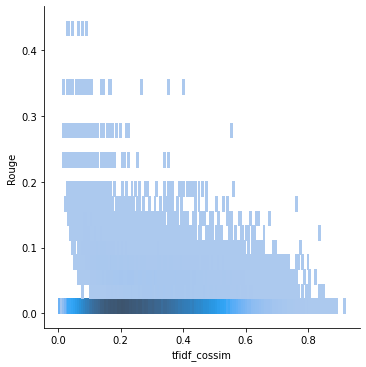

In [38]:
x = df.tfidf_cossim.agg(np.concatenate)
y = df.Rouge.agg(np.concatenate)
# sns.scatterplot(x=x, y=y)
sns.displot(x=x, y=y)
plt.xlabel('tfidf_cossim')
plt.ylabel('Rouge')
plt.show()